# Fig3. Global dry air mass conservation

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

import torch
from credit.boundary_padding import TensorPadding

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
%matplotlib inline

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
import verif_utils as vu

In [2]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 1.5
#mpl.rcParams['hatch.linewidth'] = 1.0

### Load config

In [4]:
config_name = os.path.realpath('plot_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

### Figure settings

In [5]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = conf['figure']['keys']['dpi']
else:
    dpi_ = 75

## Data

In [6]:
# RMSE line graph
load_name = conf['data']['save_loc'] + 'Conservation_results.npy'
DATA = np.load(load_name, allow_pickle=True)[()]

In [7]:
start_date = datetime(2020, 1, 1)
xticks = [start_date + timedelta(hours=i) for i in range(0, 24*(365+366), 6)]

xticklabels = []
for dt in xticks:
    xticklabels.append(datetime.strftime(dt, '%Y-%m'))

## Plot

In [8]:
my_colors = gu.ksha_color_set_summon(color_set=0)
cyan = my_colors['cyan']
blue = my_colors['blue']
red = my_colors['red']
orange = my_colors['orange']

In [9]:
# line specs
line_keys = {}
line_keys['ERA5_025'] = {'linewidth': 3, 'linestyle': '-', 'color': cyan, 'alpha': 1, 'zorder': 2, 'label': ''}
line_keys['ERA5_1deg'] = {'linewidth': 3, 'linestyle': '-', 'color': '0.5', 'alpha': 1, 'zorder': 2, 'label': ''}
line_keys['fuxi_dry'] = {'linewidth': 3, 'linestyle': '-', 'color': orange, 'alpha': 1, 'zorder': 3, 'label': ''}
line_keys['fuxi_physics'] = {'linewidth': 3, 'linestyle': '--', 'color': red, 'alpha': 1, 'zorder': 4, 'label': ''}

# lead time settings
LEADs = np.arange(6, 360+6, 6)
N_leads = len(LEADs)
LEAD_ticks = np.arange(0, 360+6, 6)[::4][::3]

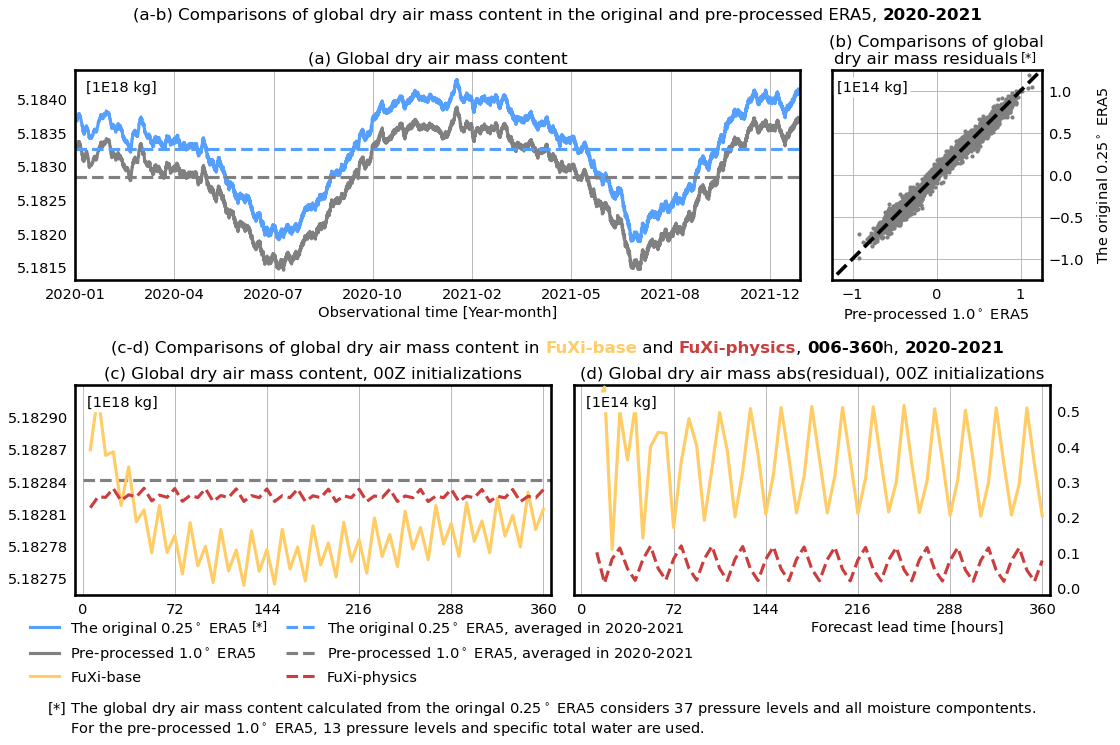

In [10]:
handles = []
L = len(DATA['ERA5_025_mass_value'])
fake_x = np.arange(L)

fig = plt.figure(figsize=(13, 7), dpi=dpi_)
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

ax1 = plt.subplot(gs[0, :3])
ax2 = plt.subplot(gs[0, 3])
ax3 = plt.subplot(gs[1, :2])
ax4 = plt.subplot(gs[1, 2:4])
AX_all = [ax1, ax2, ax3, ax4]
AX_sub = [ax3, ax4]

plt.subplots_adjust(0, 0, 1, 1, hspace=0.5, wspace=0.1)

for ax in AX_all:
    ax = gu.ax_decorate_box(ax)
    ax.tick_params(labelbottom=True, labelsize=14)
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.xaxis.grid(False)
    ax.grid(':', axis='x', zorder=4)
    
for ax in AX_sub:
    ax.set_xticks(LEAD_ticks)
    ax.set_xlim([LEAD_ticks[0]-6, LEAD_ticks[-1]+6])

ax1.tick_params(labelleft=True, labelsize=14)
ax3.tick_params(labelleft=True, labelsize=14)
ax2.tick_params(labelright=True, labelsize=14)
ax4.tick_params(labelright=True, labelsize=14)
ax2.grid(':', zorder=4)

# ===================================================================== #
# ax1

ax1.plot(fake_x, 1e-18*DATA['ERA5_025_mass_value'], **line_keys['ERA5_025'])
ax1.plot(fake_x, 1e-18*DATA['ERA5_1deg_mass_value'], **line_keys['ERA5_1deg'])

ref_ERA5_025 = DATA['ERA5_025_mass_value'].mean()
ref_ERA5_1deg = DATA['ERA5_1deg_mass_value'].mean()
ax1.hlines(y=1e-18*ref_ERA5_025, xmin=fake_x[0], xmax=fake_x[-1], linewidth=3, linestyle='--', color=cyan)
ax1.hlines(y=1e-18*ref_ERA5_1deg, xmin=fake_x[0], xmax=fake_x[-1], linewidth=3, linestyle='--', color='0.5')

ax1.text(0.015, 0.95, '[1E18 kg]', 
         ha='left', va='top', fontsize=14, transform=ax1.transAxes,
         bbox=dict(facecolor='w', alpha=1.0, edgecolor='none', boxstyle='round,pad=0.2')
        )

ax1.set_xlim([fake_x[0], fake_x[-1]])
ax1.set_xticks(fake_x[::400])
ax1.set_xticklabels(xticklabels[::400])
ax1.set_xlabel('Observational time [Year-month]', fontsize=14)
ax1.set_title('(a) Global dry air mass content', fontsize=16)

# ===================================================================== #
# ax2
ax2.plot(
    1e-14*DATA['ERA5_1deg_mass_residual'], 
    1e-14*DATA['ERA5_025_mass_residual'], 
    'ko', ms=4, mec='k', mew=0, mfc='0.5')

ax2.set_aspect('equal', adjustable='box')

ax2.text(0.025, 0.95, '[1E14 kg]', 
         ha='left', va='top', fontsize=14, transform=ax2.transAxes,
         bbox=dict(facecolor='w', alpha=1.0, edgecolor='none', boxstyle='round,pad=0.2')
        )

ax2.plot([-2, 2], [-2, 2], linestyle='--', color='k', linewidth=3.5, zorder=3)
ax2.set_xlim([-1.25, 1.25])
ax2.set_ylim([-1.25, 1.25])
ax2.set_xlabel('Pre-processed 1.0$^\circ$ ERA5', fontsize=14)
ax2.yaxis.set_label_position("right") 
ax2.set_ylabel('The original 0.25$^\circ$ ERA5', fontsize=14, labelpad=10)
ax2.set_title('(b) Comparisons of global\ndry air mass residuals    ', fontsize=16)

# ===================================================================== #
# ax3
ax3.set_title('(c) Global dry air mass content, 00Z initializations', fontsize=16)
ax3.plot(LEADs, 1e-18*DATA['fuxi_dry_mass_value'].mean(axis=0), **line_keys['fuxi_dry'])
ax3.plot(LEADs, 1e-18*DATA['fuxi_physics_mass_value'].mean(axis=0), **line_keys['fuxi_physics'])
ax3.hlines(y=1e-18*ref_ERA5_1deg, xmin=LEADs[0]-6, xmax=LEADs[-1]+6, linewidth=3, linestyle='--', color='0.5')
ax3.set_yticks([5.18275, 5.18278, 5.18281, 5.18284, 5.18287, 5.18290])

ax3.text(0.025, 0.95, '[1E18 kg]', 
         ha='left', va='top', fontsize=14, transform=ax3.transAxes,
         bbox=dict(facecolor='w', alpha=1.0, edgecolor='none', boxstyle='round,pad=0.2')
        )

# ===================================================================== #
# ax4
ax4.set_title('(d) Global dry air mass abs(residual), 00Z initializations', fontsize=16)
ax4.plot(LEADs, 1e-14*np.abs(DATA['fuxi_dry_mass_residual']).mean(axis=0), **line_keys['fuxi_dry'])
ax4.plot(LEADs, 1e-14*np.abs(DATA['fuxi_physics_mass_residual']).mean(axis=0), **line_keys['fuxi_physics'])
ax4.set_ylim([-0.02, 0.575])
ax4.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax4.text(0.025, 0.95, '[1E14 kg]', 
         ha='left', va='top', fontsize=14, transform=ax4.transAxes,
         bbox=dict(facecolor='w', alpha=1.0, edgecolor='none', boxstyle='round,pad=0.2')
        )
ax4.set_xlabel('Forecast lead time [hours]', fontsize=14, x=0.7)

# ===================================================================== #
# titles
fontsize_list = [16,]*10
fontweight_list = ['normal', 'bold']*5

ax_title0 = fig.add_axes([0.0, 1.08, 1.0, 0.04])
title_len = 0.88
handles += gu.string_partial_format(
    fig, ax_title0, 0.5*(1-title_len), 1.0, 'left', 'top', 
    [
        '(a-b) Comparisons of global dry air mass content in the original and pre-processed ERA5, ',
        '2020-2021',
    ], 
    ['k', 'k', 'k', 'k'], 
    fontsize_list, 
    fontweight_list
)


ax_title1 = fig.add_axes([0.0, 0.445, 1.0, 0.04])
title_len = 0.925
handles += gu.string_partial_format(
    fig, ax_title1, 0.5*(1-title_len), 1.0, 'left', 'top', 
    [
        '(c-d) Comparisons of global dry air mass content in ',
        'FuXi-base',
        ' and ',
        'FuXi-physics',
        ', ',
        '006-360',
        'h, ',
        '2020-2021',
    ], 
    ['k', orange, 'k', red, 'k', 'k', 'k', 'k'], 
    fontsize_list, 
    fontweight_list
)

handle_legneds1 = []
handle_legneds1.append(mlines.Line2D([], [], **line_keys['ERA5_025']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['ERA5_1deg']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['fuxi_dry']))
handle_legneds1.append(mlines.Line2D([], [], linewidth=3, linestyle='--', color=cyan))
handle_legneds1.append(mlines.Line2D([], [], linewidth=3, linestyle='--', color='0.5'))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['fuxi_physics']))

ax_lg1 = fig.add_axes([-0.055, -0.192, 0.7025, 0.17])
#ax_lg1 = fig.add_axes([0.0, -0.235, 0.7025, 0.17])
LG1 = ax_lg1.legend(
    handle_legneds1, 
    [
        'The original 0.25$^\circ$ ERA5',
        'Pre-processed 1.0$^\circ$ ERA5',
        'FuXi-base',
        'The original 0.25$^\circ$ ERA5, averaged in 2020-2021',
        'Pre-processed 1.0$^\circ$ ERA5, averaged in 2020-2021',
        'FuXi-physics'
    ], 
    bbox_to_anchor=(1, 1), ncol=2, prop={'size':14})


ax2.text(0.9035, 1.03, '[*]', ha='left', va='bottom', fontsize=12, transform=ax2.transAxes)

ax_s = fig.add_axes([0.182, -0.075, 0.015, 0.03])
ax_s.text(0.5, 0.5, '[*]', ha='center', va='center', fontsize=12, transform=ax_s.transAxes)

ax_w = fig.add_axes([-0.029, -0.265, 1.0, 0.06])
ax_w.text(
    0, 0.5, 
    '[*] The global dry air mass content calculated from the oringal 0.25$^\circ$ ERA5 '
    'considers 37 pressure levels and all moisture compontents.\n'
    '     For the pre-processed 1.0$^\circ$ ERA5, 13 pressure levels and specific total water are used.', 
    ha='left', va='center', fontsize=14, transform=ax_w.transAxes);

ax_title0.set_axis_off()
ax_title1.set_axis_off()
ax_s.set_axis_off()
ax_w.set_axis_off()

LG1 = gu.lg_box(LG1)
ax_lg1.set_axis_off()